In [89]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras import Sequential, layers
from tensorflow.keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

Note that the dataset that is used here is downloaded from kaggle

**Listing the image directories**

In [90]:
image_dir = '/kaggle/input/covid-pneumonia-normal-chest-xray-images'

classes = os.listdir(image_dir)
print(classes)

['PNEUMONIA', 'NORMAL', 'COVID']


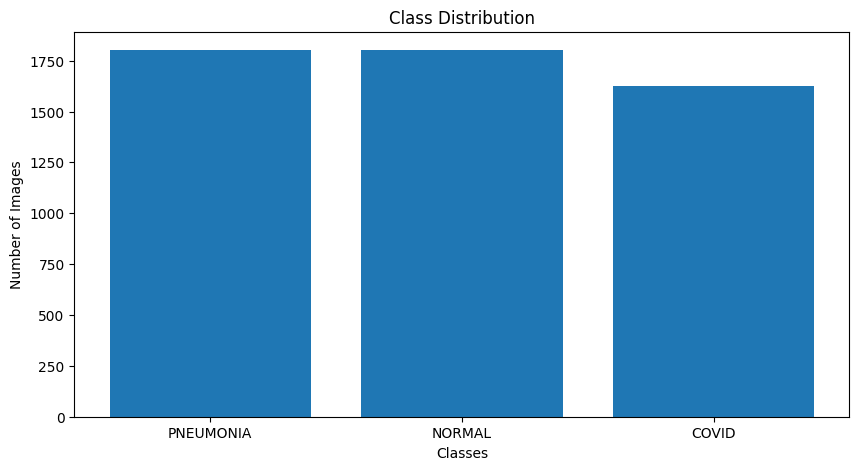

In [91]:
from collections import Counter
# Count images per class
class_counts = Counter()
for cls in classes:
    class_dir = os.path.join(image_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.show()

This seems to be a balanced dataset

**Printing sample images from each classes**

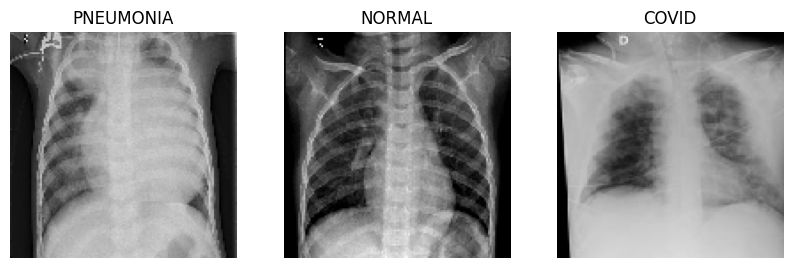

In [92]:
class_dirs = os.listdir(image_dir)
plt.figure(figsize=(10, 10))
for i, cls in enumerate(class_dirs, start=1):
    img_path = os.path.join(image_dir, cls, os.listdir(os.path.join(image_dir, cls))[0])
    img = load_img(img_path, target_size=(128, 128))
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


**Creating a Tensorflow dataset**

In [93]:
# Defining required variables
img_size = 256
batch_size = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    shuffle=True,
    image_size = (img_size,img_size),
    batch_size = batch_size,
    labels='inferred',
    label_mode='int'
)

Found 5228 files belonging to 3 classes.


**Classes**

In [94]:
class_names = dataset.class_names
print(class_names)

['COVID', 'NORMAL', 'PNEUMONIA']


In [95]:
# Length of batches
len(dataset)

164

**Splitting above tf dataset**

In [96]:
train_size = int(len(dataset)*.8)
val_size = int(len(dataset)*.1)
test_size = int(len(dataset)*.1)

In [97]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size+val_size).take(test_size)

**Let's check the split**

In [98]:
for i in [train_ds, val_ds, test_ds]:
    print(len(i))

131
16
16


**Optimize the data pipeline for training machine learning models**

In [99]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

**Defining pipeline for resizing, rescaling/normalizing the data and for data augmentation**

In [100]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_size, img_size),     # Though already resized, this works for other test data
    tf.keras.layers.Rescaling(1.0/255)     # Normalizing the pixels
])

In [101]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

**Let's define a CNN model**

In [102]:
model = Sequential()

resize_and_rescale,
data_augmentation,

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))

model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [103]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256, 256, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 128, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    67,109,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,515,011 (257.55 MB)

 Trainable params: 67,514,115 (257.55 MB)

 Non-trainable params: 896 (3.50 KB)

In [105]:
history = model.fit(train_ds, epochs = 20, batch_size = 32, verbose = 1, validation_data = val_ds)

Epoch 1/20
  1/131 ━━━━━━━━━━━━━━━━━━━━ 23:22 11s/step - accuracy: 0.3750 - loss: 2.1725

W0000 00:00:1712198365.513257     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8076 - loss: 2.2394

W0000 00:00:1712198390.946129     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.8082 - loss: 2.2345 - val_accuracy: 0.8457 - val_loss: 1.3005
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9466 - loss: 0.9173 - val_accuracy: 0.9375 - val_loss: 0.9766
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - accuracy: 0.9573 - loss: 0.8493 - val_accuracy: 0.9668 - val_loss: 0.7952
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9667 - loss: 0.7419 - val_accuracy: 0.9609 - val_loss: 0.8039
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9751 - loss: 0.6824 - val_accuracy: 0.9570 - val_loss: 0.8566
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9809 - loss: 0.6089 - val_accuracy: 0.9355 - val_loss: 0.9484
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9706 - loss: 0.6459 - val_accuracy: 0.9336 - val_loss: 0.8991
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.9834 - loss: 0.5618 - val

In [106]:
model.evaluate(test_ds)

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9877 - loss: 0.4638


[0.4864298403263092, 0.978515625]

Pretty good accuracy

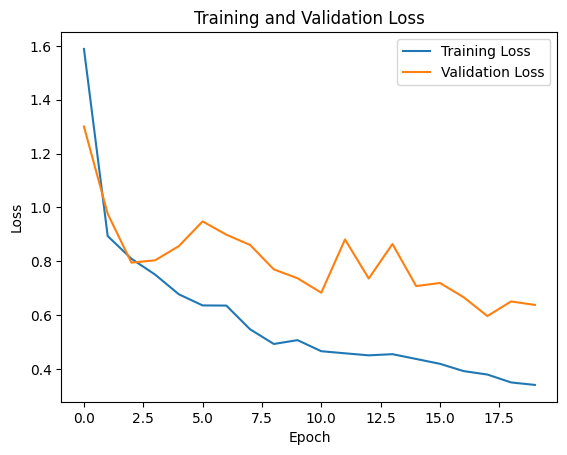

In [107]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

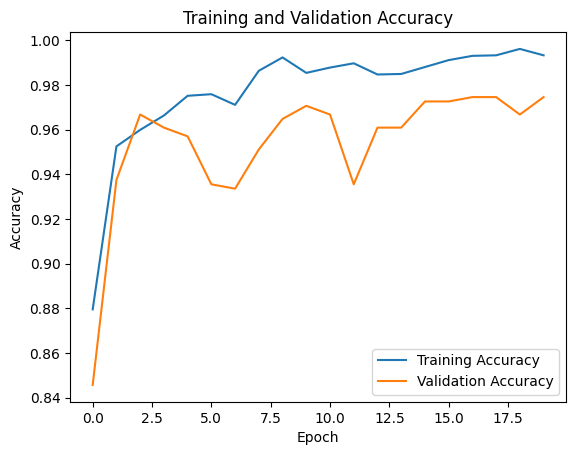

In [108]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [109]:
y_pred_probs = model.predict(test_ds)
print(y_pred_probs)

 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

W0000 00:00:1712198803.739774     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
[[8.0154769e-02 9.1966504e-01 1.8015422e-04]
 [5.6913777e-23 1.0000000e+00 3.6062825e-21]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 ...
 [1.9329859e-10 2.3610891e-08 1.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]
 [1.8501042e-15 1.0000000e+00 8.1225035e-12]]


The predicted output is the probability of the image belonging to each separate class,this is due to softmax

In [110]:
y_pred = np.argmax(y_pred_probs, axis=1)  # This returns which column has the highest value
print(y_pred)

[1 1 2 1 1 1 2 0 0 1 0 0 1 2 0 2 1 1 1 1 2 2 0 0 2 0 0 0 1 2 2 0 1 0 2 1 1
 0 0 1 0 0 1 2 2 1 1 0 2 0 1 1 1 2 0 1 2 2 2 1 0 0 2 2 1 2 1 0 0 0 1 2 1 0
 2 1 1 1 1 0 0 2 2 2 1 2 2 2 1 1 2 0 1 2 2 1 2 0 2 1 1 0 0 2 2 0 1 1 0 2 2
 1 1 2 0 1 2 1 1 0 1 2 0 0 1 0 1 2 2 0 0 1 2 1 2 0 2 1 1 0 2 0 1 0 0 2 2 2
 2 0 1 0 0 2 1 1 0 2 1 0 2 1 1 2 2 2 2 2 1 1 1 1 1 0 1 1 0 1 0 2 1 1 2 0 1
 1 1 0 2 1 2 1 1 1 2 2 0 2 2 0 1 0 1 1 2 0 0 0 2 1 2 1 0 1 1 0 2 2 1 2 1 2
 2 0 2 2 2 0 1 1 0 2 0 1 0 2 0 0 0 0 0 1 2 1 0 0 0 0 0 0 2 2 1 2 1 1 1 2 0
 2 0 2 1 2 2 1 1 2 1 2 2 0 2 0 2 2 0 0 0 1 1 2 2 2 2 2 0 2 1 0 1 1 1 2 1 2
 1 2 0 2 0 0 1 0 2 2 1 0 1 2 1 2 0 2 2 2 2 0 2 1 1 1 1 0 2 1 1 2 2 2 0 1 2
 1 2 1 2 1 2 1 2 2 0 1 2 1 1 1 1 1 0 0 0 0 2 0 2 2 1 0 1 2 2 0 2 1 2 2 1 1
 2 1 0 1 0 1 2 1 1 2 2 0 2 1 0 0 1 2 2 0 1 0 1 0 2 0 2 0 0 1 1 0 2 0 1 1 1
 0 2 1 0 0 0 1 1 0 2 2 1 1 2 1 2 2 1 1 1 2 1 2 1 0 0 0 2 2 2 1 1 0 0 1 0 0
 0 2 2 0 1 1 2 0 2 2 1 1 1 1 2 1 2 0 2 2 1 0 1 1 0 1 2 2 1 1 0 1 0 0 2 2 1
 2 0 2 2 2 1 1 2 1 0 2 1 

**Let's make predictions on some sample images**

First image to predict
First images actual label:  NORMAL
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


W0000 00:00:1712198804.788789     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Predicted label:  NORMAL


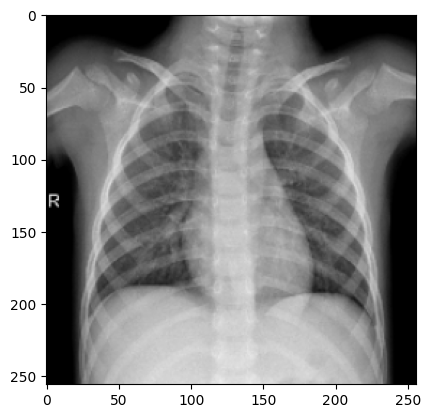

In [111]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')  # [0] gives the first image of the batch.
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('First images actual label: ', class_names[first_label]) #class_names gives the names instead of 0,1 or 2
    
    batch_prediction = model.predict(images_batch)   # This is the prediction of all 32 images of the first batch
    print('Predicted label: ' , class_names[np.argmax(batch_prediction[0])])   # this is the prediction of the first image

Let's define a function to show the **prediction confidence**

In [112]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())   # convert image into image array
    img_array = tf.expand_dims(img_array, 0)    # create a batch out of it

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Let's run the prediction on some sample images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


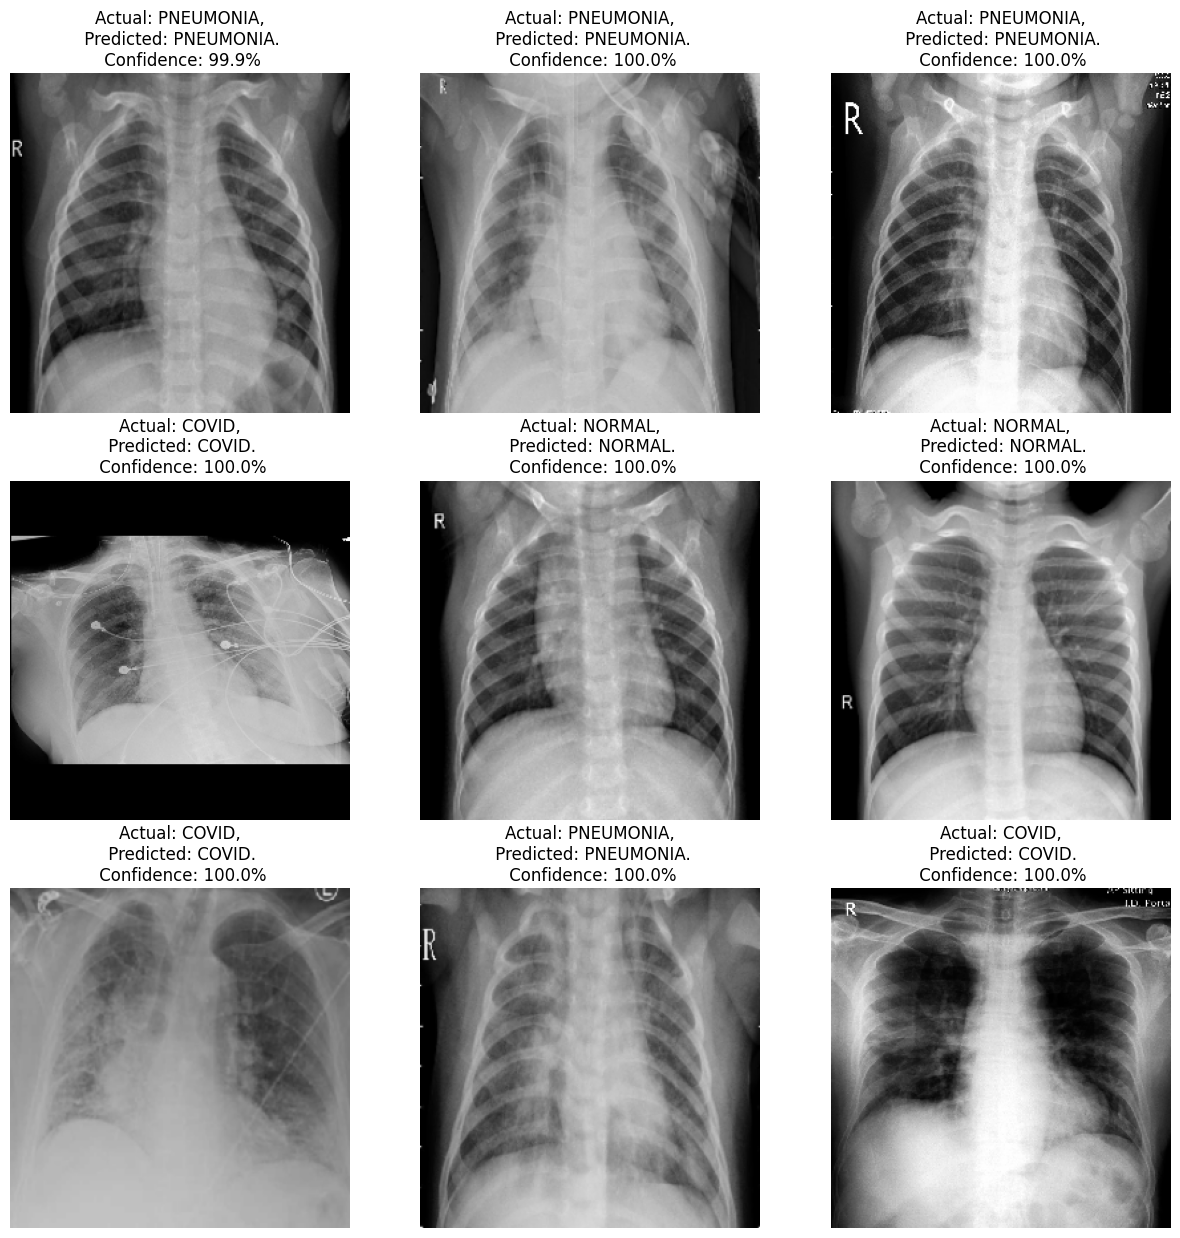

In [124]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):     # picking first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)  # subplot to show all the images
        plt.imshow(images[i].numpy().astype("uint8"))   # Show the image
        
        predicted_class, confidence = predict(model, images[i].numpy())  # Using above defined function
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

**Performance Metrics**

Calculating Precision, Recall

In [114]:
pr = Precision()
re = Recall()
ac = CategoricalAccuracy() # For binary classification, we use BinaryAccuracy

In [115]:
for batch in test_ds.as_numpy_iterator(): 
    X, y = batch
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probability scores to class labels
    pr.update_state(y, y_pred_labels)
    re.update_state(y, y_pred_labels)
    ac.update_state(y, y_pred_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [116]:
print(pr.result(), re.result(), ac.result())

tf.Tensor(0.9945652, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


**Confusion Matrix**

In [117]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for batch in test_ds.as_numpy_iterator(): 
    X, y = batch
    y_pred = model.predict(X)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probability scores to class labels
    true_labels.extend(y)
    predicted_labels.extend(y_pred_labels)

conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[144   1   1]
 [  0 183   2]
 [  0   7 174]]


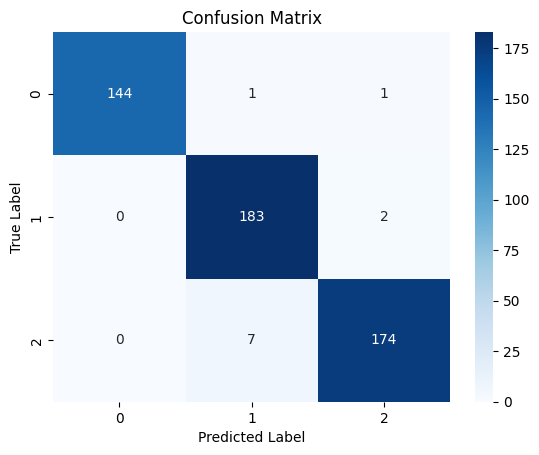

In [118]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# Labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()